<a href="https://colab.research.google.com/github/elzasmirn/ML/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений рукописных цифр

## Установка и импорт зависимостей

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.1.0)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# импортируем TensorFlow и набор данных TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
# tf.logging.set_verbosity(tf.logging.ERROR)

# вспомогательные библиотеки
import math
import numpy as np
import matplotlib.pyplot as plt

# Улучшим отображение прогрессбара
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# tf.enable_eager_execution()

2.3.0


## Импортируем набор данных MNIST

In [3]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
class_names = ["Ноль", "Один", "Два", "Три", "Четыре",
              "Пять", "Шесть", "Семь", "Восемь", "Девять"]

## Исследуем данные

In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Количество тренировочных экземпляров: {}'.format(num_train_examples))
print('Количество тестовых экземпляров: {}'.format(num_test_examples))

Количество тренировочных экземпляров: 60000
Количество тестовых экземпляров: 10000


## Предобработка данных

In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# метод map применяет функцию нормализации к каждому элементу в массиве
# тестовых и тренировочных наборах данных
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

## Изучаем обработанные данные

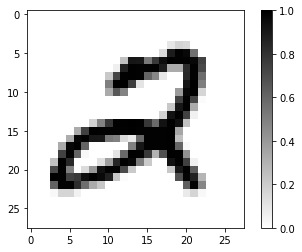

In [10]:
# Берём единственное изображение и удаляем из него цветовую составляющую
# посредством метода reshape()
for image, label in test_dataset.take(1):
  break;
image = image.numpy().reshape((28, 28))

# отрисовываем изображение
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

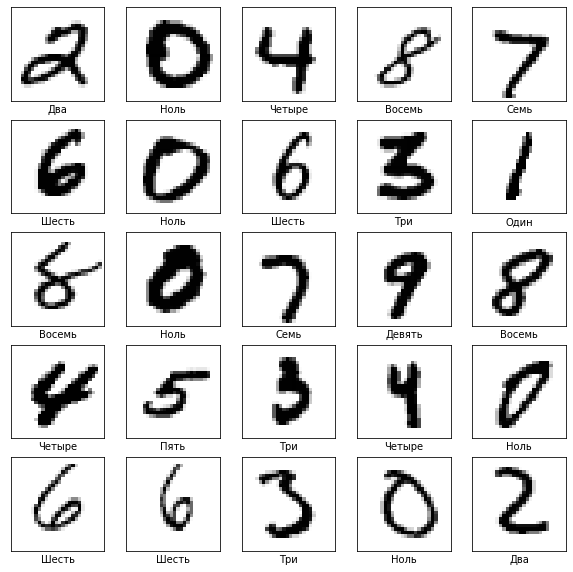

In [11]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

## Строим модель

### Настраиваем слои

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Компилируем модель

In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Тренируем модель

In [14]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2509 - accuracy: 0.9281
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1069 - accuracy: 0.9679
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0735 - accuracy: 0.9788
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0564 - accuracy: 0.9823
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0421 - accuracy: 0.9875


## Проверяем точность

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: ", test_accuracy)

313/313 [==============================] - 1s 5ms/step - loss: 0.0721 - accuracy: 0.9784
Точность на тестовом наборе данных:  0.9783999919891357


## Предсказываем и исследуем

In [17]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [18]:
predictions.shape

(32, 10)

In [19]:
predictions[0]

array([9.3062891e-11, 8.6318708e-10, 9.9999833e-01, 1.5124830e-06,
       4.6160004e-10, 1.3564612e-10, 2.6654565e-08, 5.2360161e-09,
       9.5585577e-08, 2.7155185e-09], dtype=float32)

In [20]:
np.argmax(predictions[0])

2

In [21]:
test_labels[0]

2

In [22]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

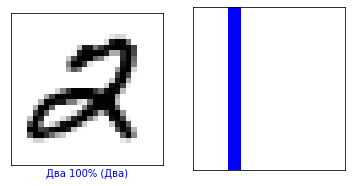

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

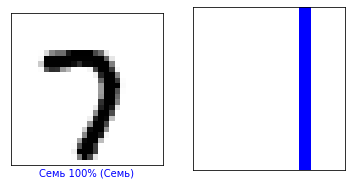

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

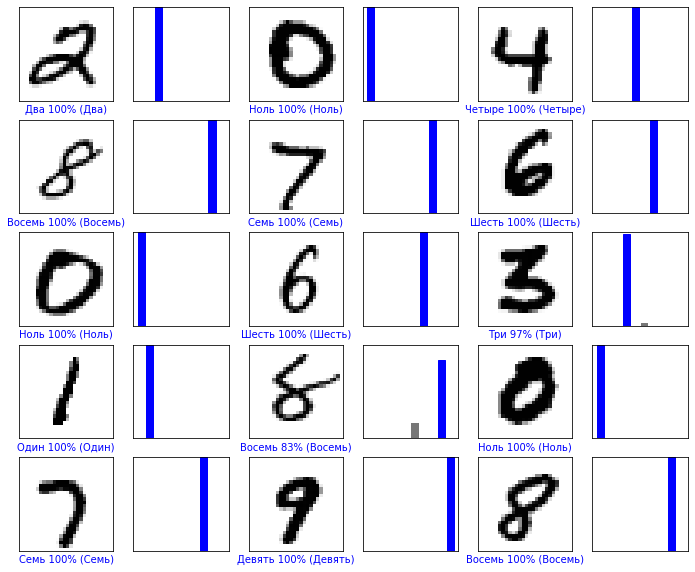

In [25]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i + 2)
  plot_value_array(i, predictions, test_labels)